In [1]:
import gridworld
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from numba import njit

In [2]:
%config InlineBackend.figure_format = "retina"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
n_rows = 7
n_cols = 10

In [5]:
init_pos = np.array([3, 0])
goal_pos = np.array([3, 7])

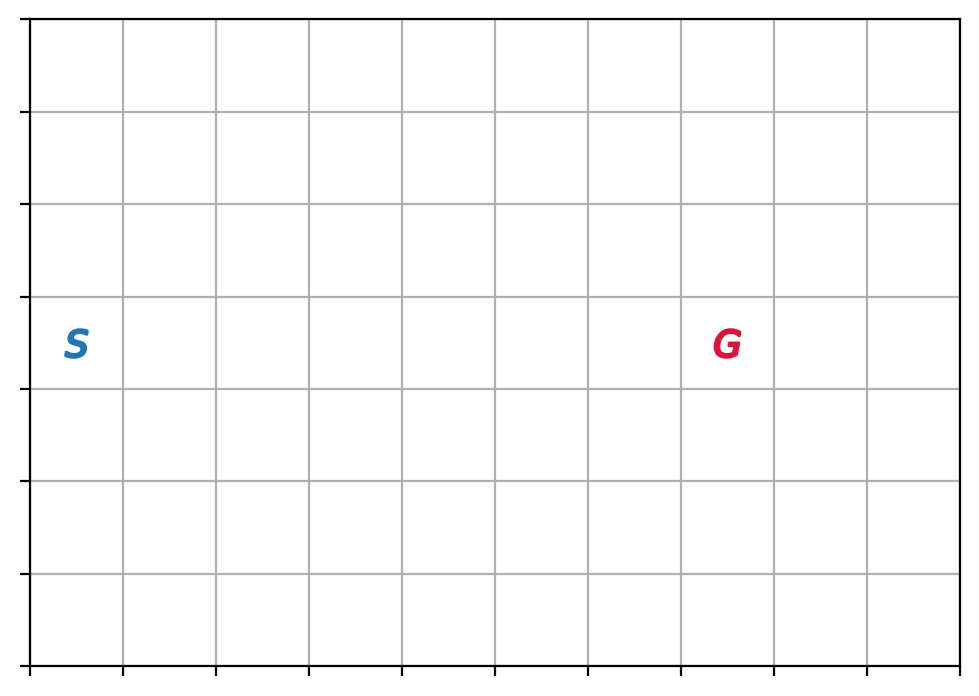

In [6]:
fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.6))
xticks = np.arange(n_cols + 1)
yticks = np.arange(n_rows + 1)

init = init_pos[::-1] + 0.5
goal = goal_pos[::-1] + 0.5
ax.scatter(*init, marker="$S$", s=100)
ax.scatter(*goal, marker="$G$", s =100, c="crimson")
# plt.scatter(*finish_pos)

ax.set_xticks(xticks, labels="")
plt.yticks(yticks, labels="")


plt.grid()

In [7]:
movements = np.array([
    [0, 1], # right
    [0, -1], # left
    [1, 0], # down,
    [-1, 0], # up
    # [0, 0], # nothing
])
n_actions = len(movements)

name_movements = ["right", "left", "down", "up"]
# name_movements = ["right", "left", "down", "up", "nothing"]

@njit
def get_probas(qval, epsilon):
    qmax = qval.max()
    n_actions = len(qval)
    mask = qmax == qval

    if np.all(mask):
        probas = np.ones(n_actions) / n_actions
    elif sum(mask) > 1:
        n_equal = sum(mask)
        probas = epsilon * np.ones(n_actions) /  n_actions
        probas = ((1 - epsilon) / n_actions + epsilon) * mask +  probas * (1 - mask)
    else:
        # return epsilon-greeedy action
        action_max = qval.argmax()
        probas = epsilon * np.ones(n_actions) / n_actions
        probas[action_max] = 1 - epsilon + epsilon / n_actions

    return probas


@njit
def choose_action(ix, Q, epsilon):
    probas = get_probas(Q[ix], epsilon)
    action = np.random.multinomial(1, probas).argmax()
    return action


@njit
def sarsa_step(s, a, Q, epsilon, gridworld):
    """
    (s, a) -> (r, s_new, a_new) --- SA-RSA
    """
    # (s, a) -> (r, s_new, a_new)

    # take action 'a', observe 'r' and s_new'
    step = movements[a]
    s_new, r = gridworld.move_and_reward(s, step)
    # Choose 'a_new' based on Q and 's_new'
    a_new = choose_action(s_new, Q, epsilon)

    q_new = Q[s, a] + alpha * (r + gamma * Q[s_new, a_new] - Q[s, a])
    return (r, s_new, a_new), q_new


def qlearning_step(s, Q, epsilon, gridworld):
    """
    s -> a -> (s_new, r_new)
    """
    # choose action 'a' based on Q and 's'
    a = choose_action(s, Q, epsilon)
    step = movements[a]
    # observe 'r' and 's_new'
    s_new, r = gridworld.move_and_reward(s, step)

    q_new = Q[s, a] + alpha * (r + gamma * Q[s_new, :].max(axis=-1) - Q[s, a])
    return (r, s_new, a), q_new

In [20]:
start_ix = 30
end_ix = 38 # 37
reward_goal = 20
G = gridworld.Gridworld(start_ix, end_ix, n_rows, n_cols, reward_goal)

In [21]:
%%time
Q = np.zeros((n_rows * n_cols, n_actions)) # action-value function

epsilon = 0.01
alpha = 0.5
gamma = 1.0

ix = start_ix
action = choose_action(ix, Q, epsilon)
ix_hist = [ix]
action_hist = [action]
reward_hist = [0]

# np.random.seed(314)
for _ in range(8000):
    # SARSA step / update
    (r, ix_new, action_new), q_new = sarsa_step(ix, action, Q, epsilon, G)
    Q[ix, action] = q_new
    ix, action = ix_new, action_new

    # Q-learning step / update
    # (r, ix_new, action), q_new = qlearning_step(ix, Q, epsilon, G)
    # Q[ix, action] = q_new
    # ix = ix_new

    action_hist.append(action)
    ix_hist.append(ix)
    reward_hist.append(r)

action_hist = np.array(action_hist)
ix_hist = np.array(ix_hist)
reward_hist = np.array(reward_hist)

CPU times: user 21.4 ms, sys: 103 µs, total: 21.5 ms
Wall time: 20.9 ms


In [22]:
reward_hist[-1000:].mean()

0.302

In [23]:
ix_goal = np.where(reward_hist == reward_goal)[0]
pos_hist = np.c_[ix_hist % n_cols, ix_hist // n_cols]
distance_hist = np.abs(pos_hist - G.get_pos(end_ix)).sum(axis=1)

In [24]:
markers = {
    "down": "v",
    "up": "^",
    "right": ">",
    "left": "<",
    "nothing": "o"
}

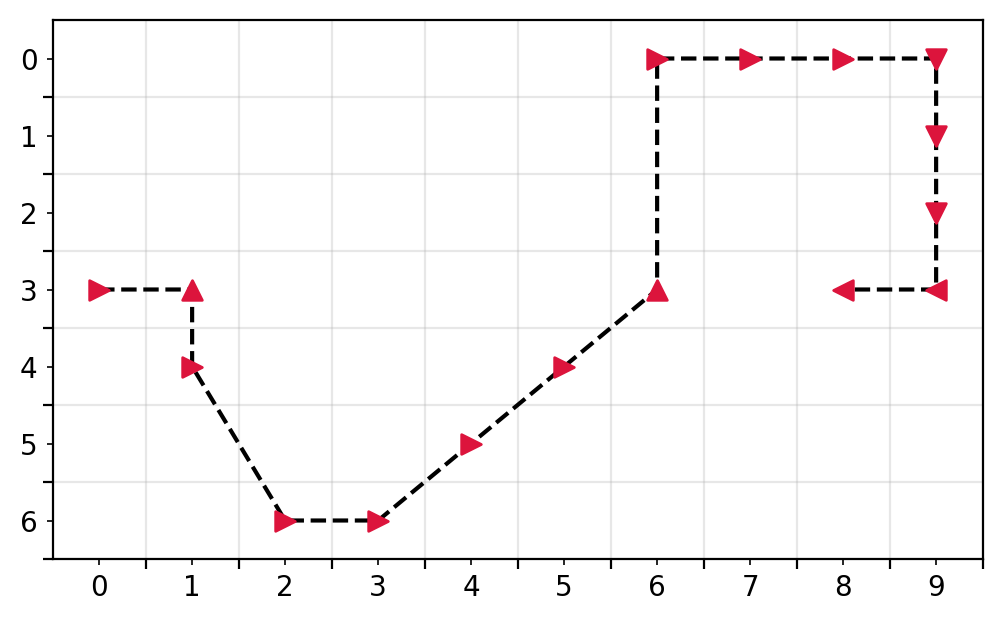

In [25]:
run = -2
iinit = ix_goal[run]
iend = ix_goal[run + 1]

subhist_action = action_hist[iinit:iend]
subhist_action = [name_movements[a] for a in subhist_action]
subhist_action = [markers[action] for action in subhist_action]

subhist_pos = pos_hist[iinit:iend]

fig, ax = plt.subplots(figsize=(n_cols * 0.6, n_rows * 0.5))
plt.plot(*subhist_pos.T, c="black", linestyle="--")

for (x,y), m in zip(subhist_pos, subhist_action):
    plt.scatter(x, y, marker=m, zorder=3, s=50, c="crimson")

xticks = np.arange(n_cols)
yticks = np.arange(n_rows)
ax.set(
    xticks=xticks + 0.5,
    yticks=yticks + 0.5,
    xticklabels="",
    yticklabels="",
)
ax.set_xticks(xticks, labels=xticks, minor=True)
ax.set_yticks(yticks, labels=yticks, minor=True)

# ax.scatter(*pos_hist[iinit], marker="$S$", s=100, zorder=3)
# ax.scatter(*pos_hist[iend-1], marker="$G$", s =100, c="crimson", zorder=3)
ax.set_ylim(-0.5, n_rows - 0.5)
ax.set_xlim(-0.5, n_cols - 0.5)
ax.invert_yaxis()

plt.grid(alpha=0.3)
plt.savefig("windy-gridworld.png", bbox_inches="tight", dpi=150)

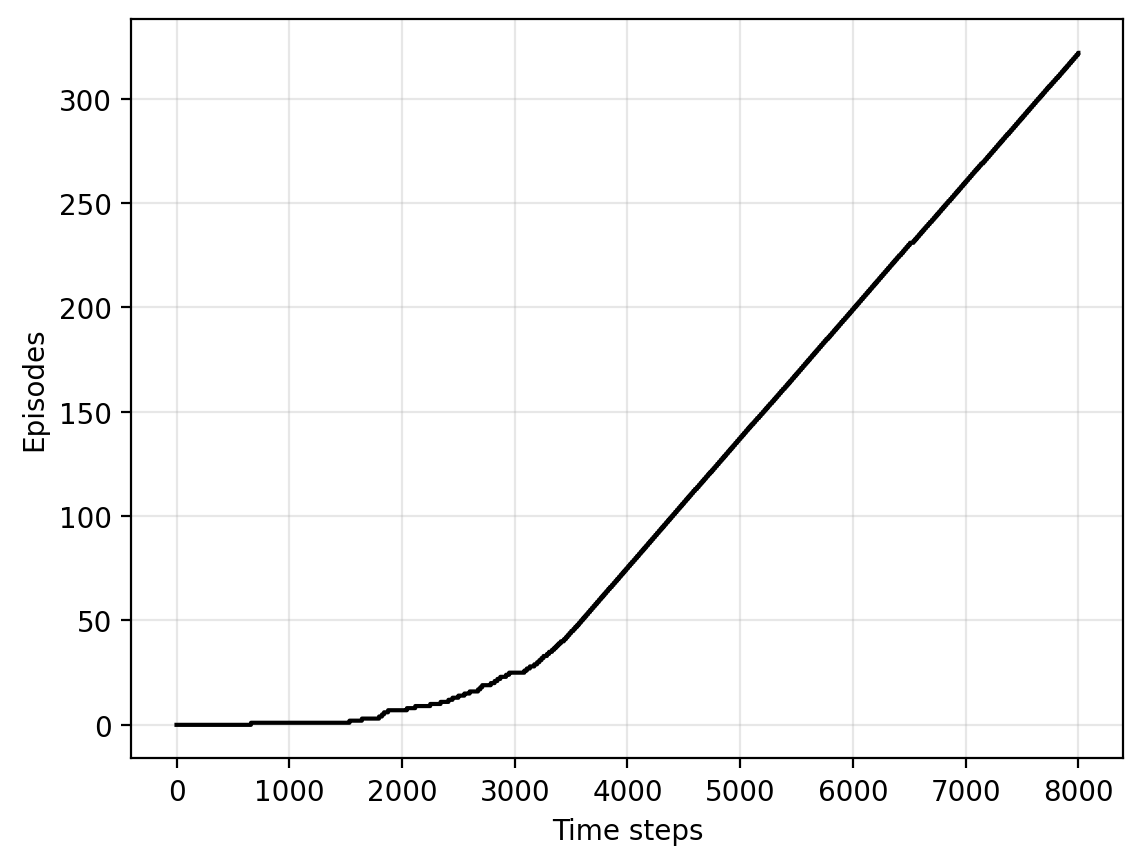

In [14]:
plt.plot((reward_hist == reward_goal).cumsum(), c="black")
plt.grid(alpha=0.3)
plt.xlabel("Time steps")
plt.ylabel("Episodes");